In [267]:
# Import những thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, roc_auc_score
from typing import List, Tuple

# Phần 1: Xây dựng mô hình hồi quy đơn biến
1. Khám phá mối liên hệ giữa chỉ số đường huyết (fbs) và bệnh tim. Tạo bảng chéo hai chiều và tóm tắt mối quan hệ.
2. Khám phá mối liên hệ giữa tuổi và bệnh tim. Tạo biểu đồ hoặc thống kê mô tả phù hợp.
3. Huấn luyện mô hình hồi quy Logistic chỉ với biến fbs (chỉ số đường huyết). Trình bày kết quả mô hình và giải thích các hệ số.
4. Viết biểu thức mô hình dựa trên các hệ số ước lượng.
5. Diễn giải ý nghĩa của e^(beta_0) trong ngữ cảnh mô hình.
6. Diễn giải ý nghĩa của e^(beta_1) (biến fbs) trong ngữ cảnh mô hình
7. Tính xác suất dự đoán mắc bệnh tim
    - Bệnh nhân có fbs = 0 (bình thường).
    - Bệnh nhân có fbs = 1 (cao).


## Câu 1: Khám phá mối liên hệ giữa chỉ số đường huyết và bệnh tim, tạo bảng chéo hai chiều và tóm tắt mối quan hệ


Bảng chéo giữa chỉ số đường huyết (fbs) và bệnh tim
target    0    1  All
fbs                  
0       114  100  214
1        17   17   34
All     131  117  248


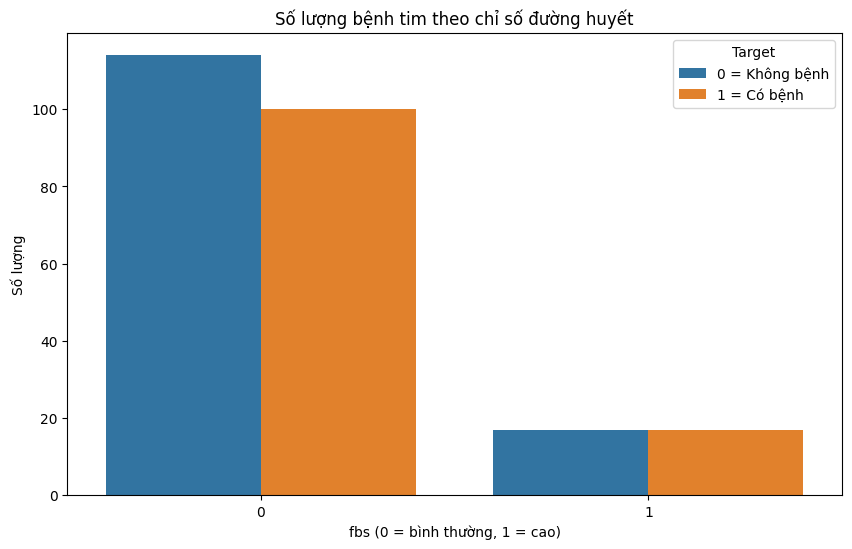

In [268]:
df = pd.read_csv("train.csv") # Câu lệnh này sẽ thực hiện từ câu hỏi bài tập 1 đến 7
# Bài 1
# Khám phá mối liên hệ giữa chỉ số đường huyết (fbs) và bệnh tim. Tạo bảng chéo hai chiều và tóm tắt mối quan hệ
crosstab_fbs = pd.crosstab(df['fbs'], df['target'], margins=True)
print("Bảng chéo giữa chỉ số đường huyết (fbs) và bệnh tim")
print(crosstab_fbs)

plt.figure(figsize=(10, 6))
sns.countplot(x='fbs', hue='target', data=df)
plt.title("Số lượng bệnh tim theo chỉ số đường huyết")
plt.xlabel("fbs (0 = bình thường, 1 = cao)")
plt.ylabel("Số lượng")
plt.legend(title='Target', labels=['0 = Không bệnh', '1 = Có bệnh'])
plt.show()

## Câu 2: Khám phá mối liên hệ giữa tuổi và bệnh tim, tạo biểu đồ hoặc thống kê mô tả phù hợp

Thống kê mô tả biến tuổi theo nhóm Target
        count   mean   std   min   25%   50%   75%   max
target                                                  
0       131.0  52.31  9.64  29.0  44.5  52.0  59.0  76.0
1       117.0  56.68  8.01  35.0  52.0  58.0  62.0  77.0


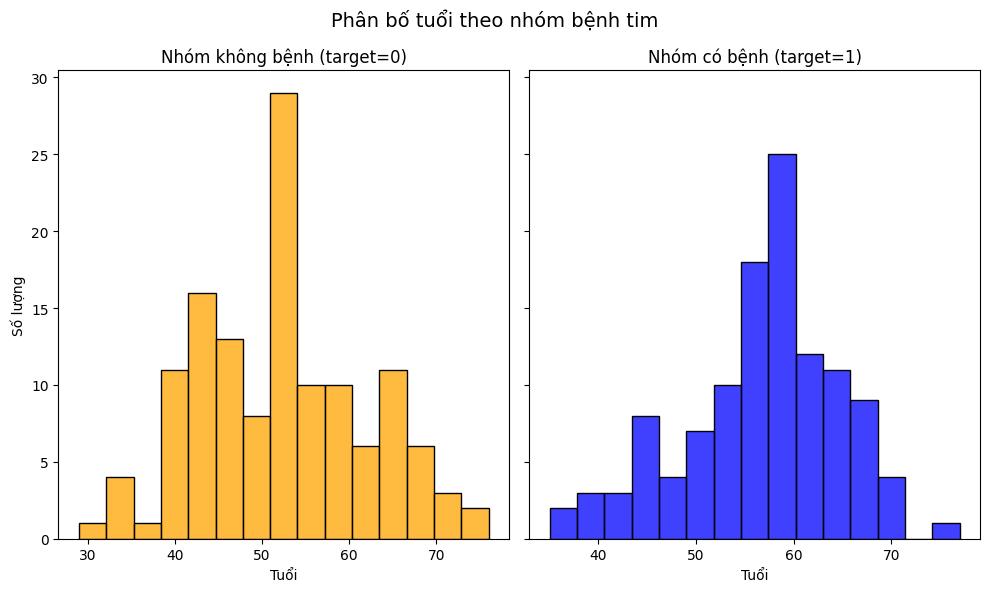

In [269]:
# Bài 2
# Khám phá mối liên hệ giữa tuổi và bệnh tim. Tạo biểu đồ hoặc thống kê mô tả phù hợp
grouped = df.groupby('target')
age_stats = grouped['age'].describe()
age_stats = age_stats.round(2)
print("Thống kê mô tả biến tuổi theo nhóm Target")
print(age_stats)

# Histogram chung cho cả hai nhóm tuổi (không dùng nữa)
# plt.figure(figsize=(10,6))
# sns.histplot(data=df, x='age', hue='target', bins=15, kde=False, alpha=0.6)
# plt.title("Phân bố tuổi theo nhóm bệnh tim")
# plt.xlabel("Tuổi")
# plt.ylabel("Số lượng")
# plt.legend(title='Target', labels=['0 = Không bệnh', '1 = Có bệnh'])
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Histogram cho nhóm không bệnh (target=0)
sns.histplot(data=df[df['target'] == 0], x='age', bins=15, kde=False, color='orange', ax=axes[0])
axes[0].set_title("Nhóm không bệnh (target=0)")
axes[0].set_xlabel("Tuổi")
axes[0].set_ylabel("Số lượng")

# Histogram cho nhóm có bệnh (target=1)
sns.histplot(data=df[df['target'] == 1], x='age', bins=15, kde=False, color='blue', ax=axes[1])
axes[1].set_title("Nhóm có bệnh (target=1)")
axes[1].set_xlabel("Tuổi")
axes[1].set_ylabel("Số lượng")

plt.suptitle("Phân bố tuổi theo nhóm bệnh tim", fontsize=14)
plt.tight_layout()
plt.show()

## Câu 3: Huấn luyện mô hình hồi quy Logistic với biến fbs

In [270]:
# Bài 3: Huấn luyện mô hình hồi quy logistic chỉ với biến fbs. Trình bày kết quả mô hình và giải thích các hệ số.
# Lớp này sẽ sử dụng cho mô hình đơn biến và đa biến
# Sinh viên đã tự xây dựng mô hình hồi quy Logistic dựa trên lý thuyết và nguồn youtube dưới đây để thiết kế thành lớp
# https://www.youtube.com/watch?v=S6iuhdYsGC8
# Lý thuyết sinh viên đã dùng để làm theo
# https://github.com/JuzerShakir/Logistic_Regression/blob/master/README.md
class LogisticRegression:
    """
        Logistic Regression được huấn luyện bằng Gradient Descent (tự cài đặt).

        Parameters
        ----------
        alpha : float, default=0.1
            Learning rate - tốc độ học.
        num_iter : int, default=100
            Số vòng lặp tối đa cho Gradient Descent.
        tol : float, default=1e-5
            Ngưỡng dừng khi gradient đủ nhỏ (hội tụ).
        scale : bool, default=False
            Nếu True, chuẩn hóa dữ liệu theo z-score trước khi huấn luyện.

        Attributes
        ----------
        theta : np.ndarray
            Vector hệ số (bao gồm cả intercept).
        X_b : np.ndarray
            Ma trận đặc trưng đã thêm cột bias (1).
        y : np.ndarray
            Vector nhãn đầu ra (0 hoặc 1).
        mean_ : np.ndarray
            Trung bình của các đặc trưng (nếu scale=True).
        std_ : np.ndarray
            Độ lệch chuẩn của các đặc trưng (nếu scale=True).
    """
    def __init__(self, alpha: float = 0.1, num_iter: int = 100, tol: float = 1e-5, scale: bool = False):
        # Khai báo tham số cơ bản (siêu tham số, hyperparameter)
        self.alpha = alpha # learning rate
        self.num_iter = num_iter # giới hạn số lần lặp
        self.tol = tol # sai số chấp nhận được
        
        # Lưu lại mấy hệ số cần thiết
        self.theta: np.ndarray | None = None # Hệ số 
        self.X_b: np.ndarray | None = None # ma trận đặc trưng nhưng lần này có thêm bias
        self.y: np.ndarray | None = None # Nhãn target
        
        # Mode scale theo z-score (Mode này là quá trình tiền xử lý dữ liệu)
        # Lý do phải tiền xử lý dữ liệu là bởi vì các đặc trưng đo trên những đơn vi khác nhau
        # Mình cần thu hẹp giá trị của các đặc trưng đó để số liệu nhỏ hơn
        # Việc sử dụng dữ liệu gốc hoàn toàn sẽ khiến cho mô hình cho ra hệ số lớn, Gradient Descent sẽ đi theo những đặc trưng số liệu lớn và học trên đó nhiều
        self.scale = scale # flag để yêu cầu scale số liệu lại (False là dùng dữ liệu gốc, True là chuẩn hóa các đặc trưng theo z-scores)
        self.mean_: np.ndarray | None = None # kì vọng
        self.std_: np.ndarray | None = None # phương sai
        
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Áp dụng hàm sigmoid để chuyển giá trị thực về [0, 1]."""
        # Trong trường hợp số quá lớn ở dương hay quá nhỏ ở âm thì sẽ thu hẹp lại nhằm tránh overflow
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))
    
    def calculate_gradient(self, theta: np.ndarray, X_b: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Tính gradient của hàm mất mát log-loss."""
        m = y.size
        return (X_b.T @ (self.sigmoid(X_b @ theta) - y)) / m
    
    def _scale_X(self, X: np.ndarray) -> np.ndarray:
        """Chuẩn hóa dữ liệu X nếu scale=True."""
        if not self.scale: # Trả về giá trị gốc nếu không bật mode scale
            return X
        return (X - self.mean_) / self.std_
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
            Huấn luyện mô hình Logistic Regression bằng Gradient Descent.

            Parameters
            ----------
            X : np.ndarray
                Ma trận đặc trưng (mẫu x đặc trưng).
            y : np.ndarray
                Vector nhãn (0 hoặc 1).
        """
        # Nếu là true, scale các thuộc tính lại 
        if self.scale:
            self.mean_ = X.mean(axis=0)
            self.std_ = X.std(axis=0, ddof=0)
            self.std_[self.std_ == 0] = 1.0
            X = self._scale_X(X)
        
        self.X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.y = y
        self.theta = np.zeros(self.X_b.shape[1])
        
        for i in range(self.num_iter):
            grad = self.calculate_gradient(self.theta, self.X_b, y)
            self.theta -= self.alpha * grad
            
            if np.linalg.norm(grad) < self.tol:
                # Cho biết đã hội tụ về
                print(f"Hội tụ sau {i+1} vòng lặp")
                break
    
    # Dự đoán xác suất sẽ mang giá trị bao nhiêu
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Dự đoán xác suất p(y=1|X)."""
        X = self._scale_X(X)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return self.sigmoid(X_b @ self.theta)
    
    # Từ giá trị sản xuất đó, với ngưỡng mặc định là 0.5, đánh nhãn mẫu thử đó là 0 hoặc 1 (ở bài này 0 là không có bệnh, 1 là có bệnh)
    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """Dự đoán nhãn (0/1) dựa trên ngưỡng xác suất."""
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        """Tính log-loss trung bình trên dữ liệu (X, y)."""
        X = self._scale_X(X)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        p = self.sigmoid(X_b @ self.theta)
        # Trong trường hợp log tiệm cận gần 0, thêm sai số để tránh log(0)
        return -np.mean(y * np.log(p + 1e-8) + (1 - y) * np.log(1 - p + 1e-8))

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """Tính accuracy của mô hình."""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    # Phương thức/hàm này có nhiệm vụ cho câu hỏi bài tập số 9 
    # (sinh viên tự xây dựng không sử dụng thư viện stats model vì stats sử dụng mô hình khác với mô hình sinh viên thực hiện)
    def summary(self, feature_names: List[str] | None = None) -> pd.DataFrame:
        """
            Trình bày bảng hệ số hồi quy cùng kiểm định thống kê.

            Parameters
            ----------
            feature_names : list[str], optional
                Tên các đặc trưng (nếu None thì mặc định là x1, x2, ...).

            Returns
            -------
            pd.DataFrame
                Bảng gồm hệ số, sai số chuẩn, z-score và p-value.
        """
        # Xác suất dự đoán
        p = self.sigmoid(self.X_b @ self.theta)
        W = np.diag(p * (1 - p))

        # Ma trận hiệp phương sai
        XtWX_inv = np.linalg.inv(self.X_b.T @ W @ self.X_b)
        # Standard error
        se = np.sqrt(np.diag(XtWX_inv))

        # Z-scores
        z_scores = self.theta / se

        # p-values
        p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

        if feature_names is None:
            feature_names = [f"x{i}" for i in range(1, len(self.theta))]
        feature_names = ["Intercept"] + feature_names

        results = pd.DataFrame({
            "Feature": feature_names,
            "Coef": self.theta,
            "StdErr": se,
            "z": z_scores,
            "p-value": p_values
        })
        return results
    

In [271]:
# Những hàm khác ngoài class
def cross_validate(model_class, X: np.ndarray, y: np.ndarray, k: int = 5, **model_params) -> Tuple[float, float, float, float]:
    """
        Thực hiện K-Fold Cross Validation cho Logistic Regression (hoặc mô hình tương tự).

        Parameters
        ----------
        model_class : class
            Lớp mô hình (ví dụ: LogisticRegression).
        X : np.ndarray
            Ma trận đặc trưng.
        y : np.ndarray
            Vector nhãn (0 hoặc 1).
        k : int, default=5
            Số lần gập (k-fold).
        **model_params : dict
            Tham số khởi tạo cho mô hình.

        Returns
        -------
        tuple
            (mean_loss, std_loss, mean_accuracy, std_accuracy)
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    losses, accs = [], []

    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = model_class(**model_params)
        model.fit(X_tr, y_tr)

        losses.append(model.loss(X_val, y_val))
        accs.append(model.score(X_val, y_val))

    return np.mean(losses), np.std(losses), np.mean(accs), np.std(accs)

def log_likelihood(model: LogisticRegression, X: np.ndarray, y: np.ndarray) -> float:
    """
        Tính log-likelihood của dữ liệu dựa trên mô hình đã huấn luyện.

        Parameters
        ----------
        model : LogisticRegression
            Mô hình đã huấn luyện.
        X : np.ndarray
            Ma trận đặc trưng.
        y : np.ndarray
            Vector nhãn (0 hoặc 1).

        Returns
        -------
        float
            Log-likelihood của dữ liệu (càng cao càng tốt).
    """
    proba = model.predict_proba(X)

    proba = np.clip(proba, 1e-15, 1 - 1e-15)
    ll = np.sum(y * np.log(proba) + (1 - y) * np.log(1 - proba))
    return ll

## Câu 4 -> Câu 7

In [272]:
# Câu 3 và câu 4
# Chuẩn bị dữ liệu
X_uni = df[['fbs']].values
y_uni = df['target'].values

# Chia 80% của train.csv để train mô hình, 20% còn lại để valid
# 298 mẫu, chia cho bên test.xlsx 50 mẫu, còn lại 248 mẫu cho train.csv
# Train lấy 80% là học trên 198 mẫu, 50 mẫu lấy làm validation (kiểm tra định kì, 50 mẫu valid sẽ được sử dụng để kiểm tra hiệu năng trước khi bỏ vào test.xlsx)
X_train_uni, X_val_uni, y_train_uni, y_val_uni = train_test_split(
    X_uni, y_uni, test_size=0.2, random_state=42, stratify=y_uni
)

# Huấn luyện với hồi quy Logistic với mô hình đơn biến (fbs)
model_uni = LogisticRegression(alpha=0.01, num_iter=50000, tol=1e-5, scale=True)
model_uni.fit(X_train_uni, y_train_uni)

# Nếu chỉ sử dụng 1 biến thì với learning rate như tham số trên thì có thể hội tụ dễ dàng được, có thể dùng scale hoặc không scale đều được
# Nếu không scale thì cũng không sao vì fbs chỉ có 2 giá trị là bình thường (0) và Cao (1).

beta_0, beta_1 = model_uni.theta
print(f"Hệ số beta0: {beta_0: .4f}")
print(f"Hệ số beta1: {beta_1: .4f}")
# Câu 4
print(f"Mô hình: p(y=1|fbs) = 1 / (1 + exp(-({beta_0:.4f} + {beta_1:.4f}*fbs)))")
# Câu 5 và Câu 6 (trong báo cáo)

Hội tụ sau 3250 vòng lặp
Hệ số beta0: -0.1214
Hệ số beta1:  0.0513
Mô hình: p(y=1|fbs) = 1 / (1 + exp(-(-0.1214 + 0.0513*fbs)))


In [273]:
# Câu 7
p_fbs0 = model_uni.predict_proba(np.array([[0]]))[0]
p_fbs1 = model_uni.predict_proba(np.array([[1]]))[0]

print(f"Xác suất mắc bệnh tim nếu fbs=0: {p_fbs0: .4f}")
print(f"Xác suất mắc bệnh tim nếu fbs=1: {p_fbs1: .4f}")

# print("Mean:", model_uni.mean_)
# print("Std:", model_uni.std_)

# print("Scaled fbs=0:", model_uni._scale_X(np.array([[0]])))
# print("Scaled fbs=1:", model_uni._scale_X(np.array([[1]])))

Xác suất mắc bệnh tim nếu fbs=0:  0.4643
Xác suất mắc bệnh tim nếu fbs=1:  0.5000


In [274]:
# Dự đoán trên tập train (80%)
train_pred_prob = model_uni.predict_proba(X_train_uni)
train_pred_class = model_uni.predict(X_train_uni)

df_train = pd.DataFrame({
    "fbs": X_train_uni.ravel(),
    "target": y_train_uni,
    "Pred_Prob": train_pred_prob,
    "Pred_Class": train_pred_class
})

print("=== Dự đoán trên tập TRAIN ===")
df_train.index = np.arange(1, len(df_train) + 1)
print(df_train.to_string())

train_acc_full = model_uni.score(X_train_uni, y_train_uni)
print(f"Accuracy TRAIN: {train_acc_full:.4f}\n")

=== Dự đoán trên tập TRAIN ===
     fbs  target  Pred_Prob  Pred_Class
1      0       0   0.464297           0
2      0       0   0.464297           0
3      0       1   0.464297           0
4      0       0   0.464297           0
5      0       0   0.464297           0
6      0       0   0.464297           0
7      1       1   0.500000           1
8      0       1   0.464297           0
9      0       0   0.464297           0
10     1       0   0.500000           1
11     0       1   0.464297           0
12     0       0   0.464297           0
13     0       1   0.464297           0
14     0       1   0.464297           0
15     0       0   0.464297           0
16     0       1   0.464297           0
17     0       0   0.464297           0
18     0       0   0.464297           0
19     0       0   0.464297           0
20     0       1   0.464297           0
21     0       0   0.464297           0
22     0       0   0.464297           0
23     0       0   0.464297           0
24     0 

In [275]:
# Dự đoán trên tập valid (20%)
val_pred_prob = model_uni.predict_proba(X_val_uni)
val_pred_class = model_uni.predict(X_val_uni)

df_valid = pd.DataFrame({
    "fbs": X_val_uni.ravel(),
    "target": y_val_uni,
    "Pred_Prob": val_pred_prob,
    "Pred_Class": val_pred_class
})

print("=== Dự đoán trên tập VALID ===")
df_valid.index = np.arange(1, len(df_valid) + 1)
print(df_valid.to_string())

val_acc_full = model_uni.score(X_val_uni, y_val_uni)
print(f"Accuracy VALID: {val_acc_full:.4f}\n")

=== Dự đoán trên tập VALID ===
    fbs  target  Pred_Prob  Pred_Class
1     0       1   0.464297           0
2     0       0   0.464297           0
3     0       0   0.464297           0
4     0       0   0.464297           0
5     0       0   0.464297           0
6     0       1   0.464297           0
7     0       1   0.464297           0
8     0       0   0.464297           0
9     0       1   0.464297           0
10    0       0   0.464297           0
11    0       0   0.464297           0
12    0       0   0.464297           0
13    0       1   0.464297           0
14    0       0   0.464297           0
15    0       1   0.464297           0
16    0       0   0.464297           0
17    0       0   0.464297           0
18    0       1   0.464297           0
19    0       0   0.464297           0
20    0       0   0.464297           0
21    0       1   0.464297           0
22    0       1   0.464297           0
23    1       1   0.500000           1
24    0       0   0.464297       

## Đánh giá hiệu năng của mô hình đơn biến

In [276]:
# Đánh giá xem mô hình hoạt động như thế nào trên tập train và tập valid
train_loss_uni = model_uni.loss(X_train_uni, y_train_uni)
val_loss_uni   = model_uni.loss(X_val_uni, y_val_uni)
train_acc_uni  = model_uni.score(X_train_uni, y_train_uni)
val_acc_uni    = model_uni.score(X_val_uni, y_val_uni)

print("=== Đánh giá Train/Validation (Đơn biến) ===")
print(f"Train Loss: {train_loss_uni:.4f}, Train Acc: {train_acc_uni:.4f}")
print(f"Valid Loss: {val_loss_uni:.4f}, Valid Acc: {val_acc_uni:.4f}\n")
# Cross-Validation
cv_loss_mean_uni, cv_loss_std_uni, cv_acc_mean_uni, cv_acc_std_uni = cross_validate(
    LogisticRegression, X_uni, y_uni, k=10,
    alpha=0.01, num_iter=50000, tol=1e-5, scale=True
)

print("=== Cross-validation (Đơn biến) ===")
print(f"CV Loss: {cv_loss_mean_uni:.4f} ± {cv_loss_std_uni:.4f}")
print(f"CV Acc:  {cv_acc_mean_uni:.4f} ± {cv_acc_std_uni:.4f}\n")

=== Đánh giá Train/Validation (Đơn biến) ===
Train Loss: 0.6910, Train Acc: 0.5303
Valid Loss: 0.6926, Valid Acc: 0.5200

Hội tụ sau 3313 vòng lặp
Hội tụ sau 3415 vòng lặp
Hội tụ sau 3206 vòng lặp
Hội tụ sau 3048 vòng lặp
Hội tụ sau 3275 vòng lặp
Hội tụ sau 3202 vòng lặp
Hội tụ sau 3161 vòng lặp
Hội tụ sau 3159 vòng lặp
Hội tụ sau 3264 vòng lặp
Hội tụ sau 3257 vòng lặp
=== Cross-validation (Đơn biến) ===
CV Loss: 0.6973 ± 0.0126
CV Acc:  0.5040 ± 0.0644



In [277]:
# Confusion Matrix
y_val_pred_uni = model_uni.predict(X_val_uni)

TP = np.sum((y_val_uni == 1) & (y_val_pred_uni == 1))
TN = np.sum((y_val_uni == 0) & (y_val_pred_uni == 0))
FP = np.sum((y_val_uni == 0) & (y_val_pred_uni == 1))
FN = np.sum((y_val_uni == 1) & (y_val_pred_uni == 0))

print("=== Confusion Matrix (Đơn biến) ===")
print(f"TN={TN}, FP={FP}")
print(f"FN={FN}, TP={TP}")

# Các chỉ số
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}\n")

=== Confusion Matrix (Đơn biến) ===
TN=24, FP=2
FN=22, TP=2
Accuracy : 0.5200
Precision: 0.5000
Recall   : 0.0833
F1-score : 0.1429



AUC (Validation - Đơn biến): 0.5032


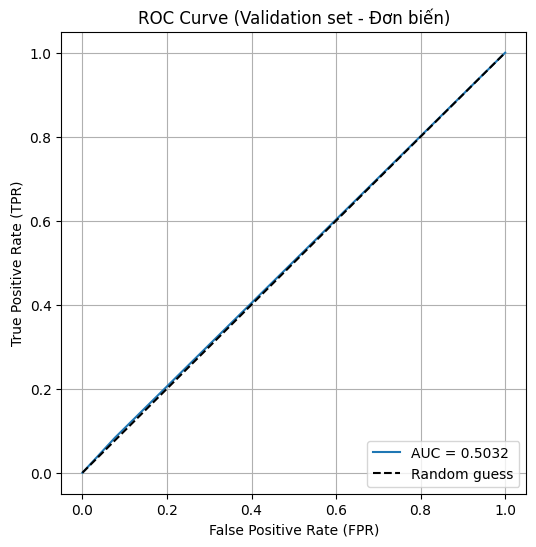

In [278]:
# AUC and ROC Curve
y_val_proba_uni = model_uni.predict_proba(X_val_uni)

fpr_uni, tpr_uni, thresholds_uni = roc_curve(y_val_uni, y_val_proba_uni)
auc_score_uni = roc_auc_score(y_val_uni, y_val_proba_uni)

print(f"AUC (Validation - Đơn biến): {auc_score_uni:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr_uni, tpr_uni, label=f"AUC = {auc_score_uni:.4f}")
plt.plot([0,1], [0,1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Validation set - Đơn biến)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Đánh giá hiệu năng mô hình đơn biến trên tập test.xlsx

In [279]:
# Test mô hình đơn biến dựa trên tập dữ liệu đó với tập dữ liệu test.xlsx
# nhằm kiểm tra xem với mô hình đơn biến, dự đoán đúng bao nhiêu phần trăm
# Tại khu vực này, em tuyên bố là không có bất cứ điều chỉnh Hyperparameter nào làm ảnh hưởng đến tính khách quan của việc kiểm tra mô hình, 
# cho dù là mô hình đơn biến noi riêng hay tổng quát nói chung
# model_uni là biến được sử dụng xuyên suốt từ câu 4, hoàn toàn không có sự điều chỉnh nào ảnh hưởng lên.
df_test = pd.read_excel("test.xlsx")

# Tách X, y
X_test_uni = df_test[["fbs"]].values
y_test_uni = df_test["target"].values

# Dự đoán
y_test_proba_uni = model_uni.predict_proba(X_test_uni)
y_test_pred_uni  = model_uni.predict(X_test_uni)

# Gắn kết quả dự đoán vào DataFrame test
df_test_result_uni = df_test[["fbs", "target"]].copy()
df_test_result_uni["Pred_Prob"]  = y_test_proba_uni
df_test_result_uni["Pred_Class"] = y_test_pred_uni

print("=== Dự đoán trên tập TEST (Đơn biến) ===")
df_test_result_uni.index = np.arange(1, len(df_test_result_uni) + 1)
print(df_test_result_uni.to_string())


=== Dự đoán trên tập TEST (Đơn biến) ===
    fbs  target  Pred_Prob  Pred_Class
1     1       0   0.500000           1
2     0       1   0.464297           0
3     0       1   0.464297           0
4     0       0   0.464297           0
5     0       0   0.464297           0
6     0       0   0.464297           0
7     0       1   0.464297           0
8     0       0   0.464297           0
9     0       1   0.464297           0
10    1       1   0.500000           1
11    0       0   0.464297           0
12    0       0   0.464297           0
13    1       1   0.500000           1
14    0       0   0.464297           0
15    1       0   0.500000           1
16    0       0   0.464297           0
17    0       1   0.464297           0
18    0       0   0.464297           0
19    0       0   0.464297           0
20    0       0   0.464297           0
21    0       0   0.464297           0
22    1       0   0.500000           1
23    0       1   0.464297           0
24    0       1   0.464

Test Loss: 0.6866, Test Acc: 0.5200

Confusion Matrix (TEST - Đơn biến):
TN=23, FP=7
FN=17, TP=3
Accuracy : 0.5200
Precision: 0.3000
Recall   : 0.1500
F1-score : 0.2000

AUC (TEST - Đơn biến): 0.4583


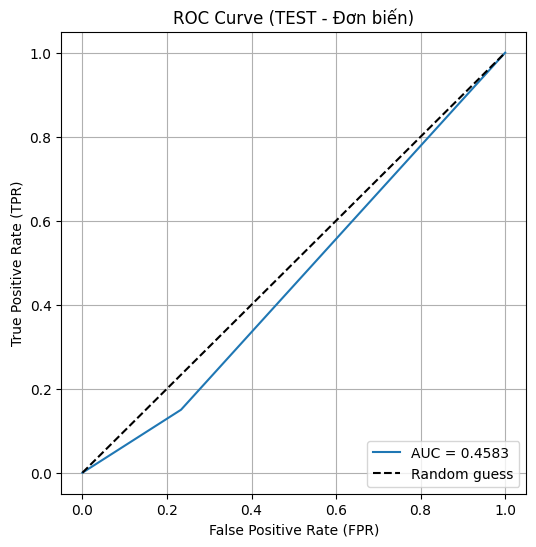

In [280]:
# Loss và Accuracy
test_loss_uni = model_uni.loss(X_test_uni, y_test_uni)
test_acc_uni  = model_uni.score(X_test_uni, y_test_uni)
print(f"Test Loss: {test_loss_uni:.4f}, Test Acc: {test_acc_uni:.4f}")

# Confusion Matrix
TP = np.sum((y_test_uni == 1) & (y_test_pred_uni == 1))
TN = np.sum((y_test_uni == 0) & (y_test_pred_uni == 0))
FP = np.sum((y_test_uni == 0) & (y_test_pred_uni == 1))
FN = np.sum((y_test_uni == 1) & (y_test_pred_uni == 0))

print("\nConfusion Matrix (TEST - Đơn biến):")
print(f"TN={TN}, FP={FP}")
print(f"FN={FN}, TP={TP}")

# Các chỉ số
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# ROC và AUC
y_test_proba_uni = model_uni.predict_proba(X_test_uni)
auc_score_uni = roc_auc_score(y_test_uni, y_test_proba_uni)
print(f"\nAUC (TEST - Đơn biến): {auc_score_uni:.4f}")

fpr, tpr, thresholds = roc_curve(y_test_uni, y_test_proba_uni)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score_uni:.4f}")
plt.plot([0,1], [0,1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (TEST - Đơn biến)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Phần 2: Xây dựng mô hình hồi quy đa biến
8. Huấn luyện mô hình hồi quy logistic sử dụng toàn bộ các biến. Viết công thức mô hình tổng quát.
9. Trình bày bảng hệ số hồi quy và xác định các biến có ý nghĩa thống kê (p < 0.05).
10. So sánh Log-Likelihood giữa mô hình đầy đủ và mô hình đơn biến. Mô hình nào tốt hơn?
11. Đánh giá hiệu năng mô hình: Accuracy, đường cong ROC và AUC. Chỉ số nào quan trọng nhất trong bài toán này?
12. Nêu một hạn chế của mô hình hồi quy logistic khi áp dụng với dữ liệu này và đề xuất hướng cải tiến.

Phần dưới đây chủ yếu là cho mô hình học trên 13 đặc trưng, cho thấy trên hai tập train và valid dự đoán thế nào

## Câu 8: Huấn luyện mô hình hồi quy Logistic nhưng dùng 13 đặc trưng y học

In [281]:
# Câu 8: Huấn luyện mô hình với 13 thuộc tính và viết công thức mô hình tổng quát
df = pd.read_csv("train.csv") # Câu lệnh này sẽ sử dụng cho câu số 8, nhằm đọc lại dữ liệu (chỉ nhằm an toàn, chắc chắn phần 2 không bị dữ liệu bên 1 ảnh hưởng)

feature_cols = df.drop(columns=['target']).columns.tolist()
X = df[feature_cols].values
y = df['target'].values

# Chia 80% của train.csv để train mô hình, 20% còn lại để valid
# 298 mẫu, chia cho bên test.xlsx 50 mẫu, còn lại 248 mẫu cho train.csv
# Train lấy 80% là học trên 198 mẫu, 50 mẫu lấy làm validation

# Ở mô hình đa biến sẽ sử dụng tên biến thường dùng (vì đây là mô hình chính, đơn biến sẽ để tên riêng là thêm hậu tố _uni ở sau các biến)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_multi = LogisticRegression(alpha=0.01, num_iter=50000, tol=1e-5, scale=True)
model_multi.fit(X_train, y_train)

theta = model_multi.theta
print(f"beta_0 (intercept): {theta[0]:.4f}") # Bias
for i, col in enumerate(df.drop(columns=['target']).columns, start=1): # Từ 1 đến 13 (age -> thal)
    print(f"beta_{i} ({col}): {theta[i]:.4f}")

formula = "p(y=1|X) = 1 / (1 + exp(-(" + " + ".join(
    [f"{theta[0]:.4f}"] + [f"{theta[i]:.4f}*{col}" for i, col in enumerate(df.drop(columns=['target']).columns, start=1)]
) + ")))"
print(formula)


Hội tụ sau 21017 vòng lặp
beta_0 (intercept): -0.0508
beta_1 (age): 0.0362
beta_2 (sex): 0.5808
beta_3 (cp): 0.6381
beta_4 (trestbps): 0.6233
beta_5 (chol): 0.0147
beta_6 (fbs): -0.1809
beta_7 (restecg): 0.0561
beta_8 (thalach): -0.4327
beta_9 (exang): 0.4356
beta_10 (oldpeak): 0.4854
beta_11 (slope): 0.1959
beta_12 (ca): 0.8867
beta_13 (thal): 0.5708
p(y=1|X) = 1 / (1 + exp(-(-0.0508 + 0.0362*age + 0.5808*sex + 0.6381*cp + 0.6233*trestbps + 0.0147*chol + -0.1809*fbs + 0.0561*restecg + -0.4327*thalach + 0.4356*exang + 0.4854*oldpeak + 0.1959*slope + 0.8867*ca + 0.5708*thal)))


In [282]:
# Trên 80% dữ liệu của train.csv, mô hình dự đoán như thế nào
train_pred_prob = model_multi.predict_proba(X_train)
train_pred_class = model_multi.predict(X_train)

df_train = pd.DataFrame(X_train, columns=feature_cols)
# Ban đầu, DataFrame sẽ không có cột target, mô hình sẽ sử dụng 80% dữ liệu của train.csv để học
# Sau khi học xong, nối dataframe 3 cột là target (nhãn đúng), Pred_Prob (ứng với 1 người là 1 mẫu: xác suất dự đoán là bao nhiêu) và Pred_Class (nhãn mô hình suy ra)
# Đối chiếu các Target với Pred_Class để xem là mô hình đoán đúng bao nhiêu % trên tập Train (1 đến 198)
df_train["target"] = y_train
df_train["Pred_Prob"] = train_pred_prob
df_train["Pred_Class"] = train_pred_class

print("=== Dự đoán trên tập TRAIN ===")
df_train.index = np.arange(1, len(df_train) + 1)
print(df_train.to_string())

train_acc_full = model_multi.score(X_train, y_train)
print(f"Accuracy TRAIN: {train_acc_full:.4f}\n")

=== Dự đoán trên tập TRAIN ===
      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  slope   ca  thal  target  Pred_Prob  Pred_Class
1    46.0  0.0  3.0     142.0  177.0  0.0      2.0    160.0    1.0      1.4    3.0  0.0   3.0       0   0.321091           0
2    45.0  1.0  4.0     104.0  208.0  0.0      2.0    148.0    1.0      3.0    2.0  0.0   3.0       0   0.603421           1
3    67.0  1.0  4.0     100.0  299.0  0.0      2.0    125.0    1.0      0.9    2.0  2.0   3.0       1   0.861844           1
4    52.0  1.0  2.0     120.0  325.0  0.0      0.0    172.0    0.0      0.2    1.0  0.0   3.0       0   0.035668           0
5    43.0  1.0  4.0     115.0  303.0  0.0      0.0    181.0    0.0      1.2    2.0  0.0   3.0       0   0.174694           0
6    59.0  1.0  2.0     140.0  221.0  0.0      0.0    164.0    1.0      0.0    1.0  0.0   3.0       0   0.166138           0
7    67.0  1.0  4.0     125.0  254.0  1.0      0.0    163.0    0.0      0.2    2.0  2.0   7.0 

In [283]:
# Trên 20% còn lại, mô hình dự đoán như thế nào
val_pred_prob = model_multi.predict_proba(X_val)
val_pred_class = model_multi.predict(X_val)

# Ban đầu, DataFrame sẽ không có cột target, mô hình sẽ sử dụng 80% dữ liệu của train.csv để học
# Sau khi học xong, nối dataframe 3 cột là target (nhãn đúng), Pred_Prob (ứng với 1 người là 1 mẫu: xác suất dự đoán là bao nhiêu) và Pred_Class (nhãn mô hình suy ra)
# Đối chiếu các Target với Pred_Class để xem là mô hình đoán đúng bao nhiêu % trên tập Train (199 -> 248)

# Lấy 20% còn lại của train.csv cho model kiểm tra xem dự đoán tốt bao nhiêu
df_valid = pd.DataFrame(X_val, columns=feature_cols)
df_valid["target"] = y_val
df_valid["Pred_Prob"] = val_pred_prob
df_valid["Pred_Class"] = val_pred_class

print("=== Dự đoán trên tập VALID ===")
df_valid.index = np.arange(1, len(df_valid) + 1)
print(df_valid.to_string())

val_acc_full = model_multi.score(X_val, y_val)
print(f"Accuracy VALID: {val_acc_full:.4f}\n")

=== Dự đoán trên tập VALID ===
     age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  slope   ca  thal  target  Pred_Prob  Pred_Class
1   61.0  1.0  4.0     120.0  260.0  0.0      0.0    140.0    1.0      3.6    2.0  1.0   7.0       1   0.968837           1
2   60.0  0.0  3.0     102.0  318.0  0.0      0.0    160.0    0.0      0.0    1.0  1.0   3.0       0   0.033630           0
3   43.0  1.0  4.0     110.0  211.0  0.0      0.0    161.0    0.0      0.0    1.0  0.0   7.0       0   0.269591           0
4   54.0  0.0  3.0     160.0  201.0  0.0      0.0    163.0    0.0      0.0    1.0  1.0   3.0       0   0.190469           0
5   44.0  0.0  3.0     108.0  141.0  0.0      0.0    175.0    0.0      0.6    2.0  0.0   3.0       0   0.019710           0
6   61.0  1.0  4.0     140.0  207.0  0.0      2.0    138.0    1.0      1.9    1.0  1.0   7.0       1   0.963354           1
7   44.0  1.0  4.0     112.0  290.0  0.0      2.0    153.0    0.0      0.0    1.0  1.0   3.0       1 

## Câu 9: Trình bày bảng hệ số hồi quy và xác định biến nào có ý nghĩa thống kê (p < 0.05)

In [284]:
df = pd.read_csv("train.csv") # Câu lệnh này nhằm mục đích reset lại để kiểm định thống kê
X_table = df.drop(columns=['target']).values
y_table = df['target'].values

model_multi_table = LogisticRegression(alpha=0.01, num_iter=50000, tol=1e-5, scale=False)
model_multi_table.fit(X_table, y_table)

# In bảng hệ số + kiểm định thống kê
"""
    Dựa theo bảng hệ số hồi quy thì ta có thể thấy được như sau
        - Hệ số của một số đặc trưng không đều (một số thuộc tính sẽ có giá trị quá lớn trong khi đó lại có thuộc tính lại quá nhỏ, ví dụ như fbs chỉ có 0 và 1, age thì dao động tuổi từ 30-70)
        - Việc sử dụng không chuẩn hóa theo phân phối chuẩn (z-scores) dẫn đến sai số quá cao, p-value cũng gần chạm đến 1, ta khó có thể đánh giá đặc trưng nào thực sự có ý nghĩa thống kê.
            Việc giữ theo số liệu gốc mà không chuẩn hóa thì giống như ta coi 13 đặc trưng y học là không có ý nghĩa trong thống kê ????
        - Gradient Descent khi gặp đặc trưng quá lớn thì sẽ đi theo đặc trưng đó, trong khi một số đặc trưng khác thì giá trị lại quá nhỏ.
        => Cần chuẩn hóa số liệu đặc trưng lại (bao gồm khi train, valid và test) nhằm giảm hệ số nhỏ lại, sai số sẽ nhỏ hơn, đánh giá p-value có ý nghĩa hơn
"""
feature_cols = df.drop(columns=['target']).columns.tolist()
summary_table = model_multi_table.summary(feature_names=feature_cols)
print(summary_table)
sig_vars = summary_table[summary_table["p-value"] < 0.05]
print("\nCác biến có ý nghĩa thống kê (p < 0.05):")
print(sig_vars)

      Feature       Coef      StdErr         z   p-value
0   Intercept  -0.585091  868.672027 -0.000674  0.999463
1         age  -3.036841   38.673646 -0.078525  0.937411
2         sex  12.946768   94.380999  0.137176  0.890892
3          cp  23.790383  145.140741  0.163913  0.869800
4    trestbps   0.665868    3.701055  0.179913  0.857221
5        chol   0.012921    0.604558  0.021372  0.982949
6         fbs  -2.803879  485.259769 -0.005778  0.995390
7     restecg   6.476366   49.292419  0.131387  0.895469
8     thalach  -1.321574   12.375853 -0.106787  0.914958
9       exang  15.703452  157.878002  0.099466  0.920768
10    oldpeak  24.222309  140.091445  0.172904  0.862727
11      slope   5.713746  131.436306  0.043472  0.965326
12         ca  41.843286  578.067099  0.072385  0.942296
13       thal  27.988738  306.269972  0.091386  0.927186

Các biến có ý nghĩa thống kê (p < 0.05):
Empty DataFrame
Columns: [Feature, Coef, StdErr, z, p-value]
Index: []


In [285]:
df = pd.read_csv("train.csv") # Câu lệnh này nhằm mục đích reset lại để kiểm định thống kê
X_table = df.drop(columns=['target']).values
y_table = df['target'].values

model_multi_table_2 = LogisticRegression(alpha=0.01, num_iter=50000, tol=1e-5, scale=True)
model_multi_table_2.fit(X_table, y_table)

# In bảng hệ số + kiểm định thống kê
feature_cols = df.drop(columns=['target']).columns.tolist()
summary_table = model_multi_table_2.summary(feature_names=feature_cols)
print(summary_table)
sig_vars = summary_table[summary_table["p-value"] < 0.05]
print("\nCác biến có ý nghĩa thống kê (p < 0.05):")
print(sig_vars)

Hội tụ sau 24299 vòng lặp
      Feature      Coef    StdErr         z   p-value
0   Intercept -0.004026  0.201677 -0.019963  0.984073
1         age -0.210335  0.234288 -0.897764  0.369311
2         sex  0.609197  0.246195  2.474453  0.013344
3          cp  0.526748  0.205486  2.563421  0.010365
4    trestbps  0.605187  0.214384  2.822905  0.004759
5        chol  0.159724  0.213635  0.747646  0.454673
6         fbs -0.273965  0.217505 -1.259576  0.207822
7     restecg  0.065810  0.203118  0.323998  0.745940
8     thalach -0.536089  0.256877 -2.086947  0.036893
9       exang  0.459803  0.213190  2.156772  0.031023
10    oldpeak  0.322744  0.279079  1.156459  0.247493
11      slope  0.272768  0.246003  1.108799  0.267517
12         ca  1.156641  0.267824  4.318658  0.000016
13       thal  0.621587  0.212356  2.927103  0.003421

Các biến có ý nghĩa thống kê (p < 0.05):
     Feature      Coef    StdErr         z   p-value
2        sex  0.609197  0.246195  2.474453  0.013344
3         cp  0.

## Câu 10: So sánh Log-Likelihood của mô hình đơn biến và đầy đủ, đánh giá mô hình nào tốt hơn ?

In [286]:
# Khi không chuẩn hóa về Z-score
X_uni = df[['fbs']].values
y = df['target'].values

model_uni_log = LogisticRegression(alpha=0.01, num_iter=50000, tol=1e-5, scale=False)
model_uni_log.fit(X_uni, y)
ll_uni = log_likelihood(model_uni_log, X_uni, y)

X_multi = df.drop(columns=['target']).values

model_multi_log = LogisticRegression(alpha=0.01, num_iter=50000, tol=1e-5, scale=False)
model_multi_log.fit(X_multi, y)
ll_multi = log_likelihood(model_multi_log, X_multi, y)

print(f"Log-Likelihood mô hình đơn biến (fbs): {ll_uni:.4f}")
print(f"Log-Likelihood mô hình đa biến (full): {ll_multi:.4f}")

Hội tụ sau 20977 vòng lặp
Log-Likelihood mô hình đơn biến (fbs): -171.4422
Log-Likelihood mô hình đa biến (full): -1193.1936


In [287]:
# Khi chuẩn hóa về Z-score
X_uni = df[['fbs']].values
y = df['target'].values

model_uni_log = LogisticRegression(alpha=0.01, num_iter=50000, tol=1e-5, scale=True)
model_uni_log.fit(X_uni, y)
ll_uni = log_likelihood(model_uni_log, X_uni, y)

X_multi = df.drop(columns=['target']).values

model_multi_log = LogisticRegression(alpha=0.01, num_iter=50000, tol=1e-5, scale=True)
model_multi_log.fit(X_multi, y)
ll_multi = log_likelihood(model_multi_log, X_multi, y)

print(f"Log-Likelihood mô hình đơn biến (fbs): {ll_uni:.4f}")
print(f"Log-Likelihood mô hình đa biến (full): {ll_multi:.4f}")

Hội tụ sau 3216 vòng lặp
Hội tụ sau 24299 vòng lặp
Log-Likelihood mô hình đơn biến (fbs): -171.4422
Log-Likelihood mô hình đa biến (full): -86.5227


## Câu 11: Đánh giá hiệu năng mô hình: Accuracy, đường cong ROC và AUC. Chỉ số nào quan trọng nhất trong bài toán này?
Sử dụng test.xlsx để đánh giá hiệu năng mô hình thực sự tốt hay không

In [288]:
# So sánh giữa train và valid trên mô hình đa biến
# Kiểm tra tổng quát xem mô hình hoạt động có tốt hay không
# Khu vực này để đánh giá về mất mát của mô hình trên train và valid trước thềm test.xlsx
train_loss = model_multi.loss(X_train, y_train)
val_loss = model_multi.loss(X_val, y_val)
train_acc = model_multi.score(X_train, y_train)
val_acc = model_multi.score(X_val, y_val)

print("=== Đánh giá Train/Validation ===")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}\n")

cv_loss_mean, cv_loss_std, cv_acc_mean, cv_acc_std = cross_validate(
    LogisticRegression, X, y, k=10,
    alpha=0.01, num_iter=50000, tol=1e-5, scale=True
)

print("\n=== Cross-validation ===")
print(f"CV Loss: {cv_loss_mean:.4f} ± {cv_loss_std:.4f}")
print(f"CV Acc: {cv_acc_mean:.4f} ± {cv_acc_std:.4f}")

=== Đánh giá Train/Validation ===
Train Loss: 0.3587, Train Acc: 0.8636
Valid Loss: 0.3409, Valid Acc: 0.8600

Hội tụ sau 26145 vòng lặp
Hội tụ sau 24882 vòng lặp
Hội tụ sau 22748 vòng lặp
Hội tụ sau 26493 vòng lặp
Hội tụ sau 22380 vòng lặp
Hội tụ sau 23748 vòng lặp
Hội tụ sau 25030 vòng lặp
Hội tụ sau 28520 vòng lặp
Hội tụ sau 23958 vòng lặp
Hội tụ sau 26020 vòng lặp

=== Cross-validation ===
CV Loss: 0.4158 ± 0.1156
CV Acc: 0.8145 ± 0.0674


In [289]:
# confusion matrix
y_val_pred = model_multi.predict(X_val)

TP = np.sum((y_val == 1) & (y_val_pred == 1))
TN = np.sum((y_val == 0) & (y_val_pred == 0))
FP = np.sum((y_val == 0) & (y_val_pred == 1))
FN = np.sum((y_val == 1) & (y_val_pred == 0))

print("Confusion Matrix:")
print(f"TN={TN}, FP={FP}")
print(f"FN={FN}, TP={TP}")

# Các chỉ số đánh giá
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Confusion Matrix:
TN=24, FP=2
FN=5, TP=19
Accuracy : 0.8600
Precision: 0.9048
Recall   : 0.7917
F1-score : 0.8444


AUC (Validation): 0.9343


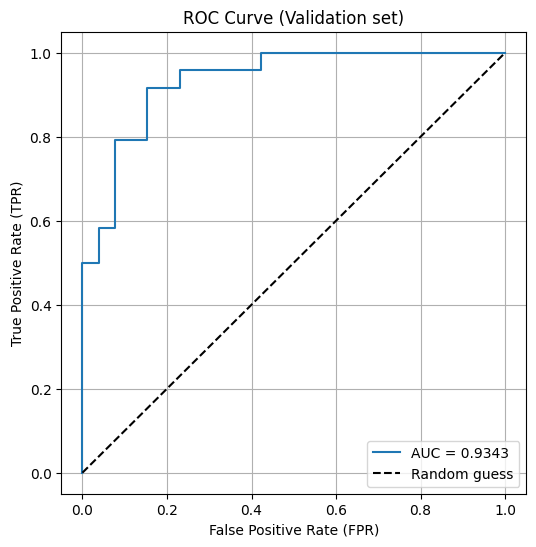

In [290]:
y_val_proba = model_multi.predict_proba(X_val)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

# AUC
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"AUC (Validation): {auc_score:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Validation set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Đánh giá hiệu năng của mô hình đa biến trên tập test.xlsx

In [291]:
# Đánh giá cuối cùng mô hình đa biến trên tập test.xlsx
# Tại ô code này, tuyên bố không có bất kì sự tùy chỉnh siêu tham số nào ảnh hưởng đến tính khách quan của mô hình
df_test = pd.read_excel("test.xlsx")
X_test = df_test[feature_cols].values
y_test = df_test["target"].values

# Dự đoán
y_test_proba = model_multi.predict_proba(X_test)
y_test_pred = model_multi.predict(X_test)

df_test["Pred_Prob"]  = y_test_proba
df_test["Pred_Class"] = y_test_pred

# Loss và accuracy
test_loss = model_multi.loss(X_test, y_test)
test_acc = model_multi.score(X_test, y_test)

# Bảng dự đoán
df_test.index = np.arange(1, len(df_test) + 1)
print(df_test.to_string())


    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  ca  thal  target  Pred_Prob  Pred_Class
1    63    1   1       145   233    1        2      150      0      2.3      3   0     6       0   0.326885           0
2    67    1   4       160   286    0        2      108      1      1.5      2   3     3       1   0.995530           1
3    67    1   4       120   229    0        2      129      1      2.6      2   2     7       1   0.986550           1
4    37    1   3       130   250    0        0      187      0      3.5      3   0     3       0   0.344658           0
5    41    0   2       130   204    0        2      172      0      1.4      1   0     3       0   0.024922           0
6    56    1   2       120   236    0        0      178      0      0.8      1   0     3       0   0.039964           0
7    62    0   4       140   268    0        2      160      0      3.6      3   2     3       1   0.856516           1
8    57    0   4       120   354    0   

==== ĐÁNH GIÁ TEST ====
Test Loss: 0.3723, Test Acc: 0.8400

Confusion Matrix (TEST):
TN=26, FP=4
FN=4, TP=16
Accuracy : 0.8400
Precision: 0.8000
Recall   : 0.8000
F1-score : 0.8000

AUC (TEST): 0.8733


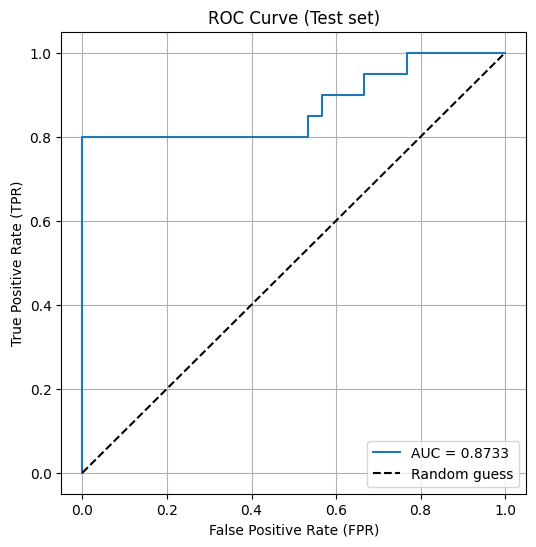

In [292]:
print("==== ĐÁNH GIÁ TEST ====")
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
# Confusion Matrix
TP = np.sum((y_test == 1) & (y_test_pred == 1))
TN = np.sum((y_test == 0) & (y_test_pred == 0))
FP = np.sum((y_test == 0) & (y_test_pred == 1))
FN = np.sum((y_test == 1) & (y_test_pred == 0))

print("\nConfusion Matrix (TEST):")
print(f"TN={TN}, FP={FP}")
print(f"FN={FN}, TP={TP}")

# Metrics
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

print(f"\nAUC (TEST): {auc_score:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], "k--", label="Random guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Test set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Đối chiếu với thư viện của statmodel.api

In [293]:
# import statsmodels.api as sm
# Đọc dữ liệu
# Mô hình mà thư viện này sử dụng khác với sinh viên làm nên dùng để so sánh và đối chiếu về bảng và log-likelihood
df = pd.read_csv("train.csv")

X = df.drop(columns=['target'])
y = df['target']

# Thêm cột hằng số để ước lượng Intercept
X = sm.add_constant(X)

# Fit mô hình Logistic Regression (dùng statsmodels)
model = sm.Logit(y, X)
result = model.fit()

# In ra bảng hệ số + kiểm định thống kê
print(result.summary())

# Lấy bảng hệ số dưới dạng DataFrame để lọc biến có ý nghĩa
summary_table = result.summary2().tables[1]  # Bảng hệ số
print(summary_table)

sig_vars = summary_table[summary_table["P>|z|"] < 0.05]
print("\nCác biến có ý nghĩa thống kê (p < 0.05):")
print(sig_vars)

Optimization terminated successfully.
         Current function value: 0.348882
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  248
Model:                          Logit   Df Residuals:                      234
Method:                           MLE   Df Model:                           13
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:                  0.4955
Time:                        01:51:48   Log-Likelihood:                -86.523
converged:                       True   LL-Null:                       -171.51
Covariance Type:            nonrobust   LLR p-value:                 1.877e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7346      3.088     -2.181      0.029     -12.786      -0.683
age           -0.0230      0.